# 처음으로 돌아가자

모든걸 다했지만 계속 점수가 똥망이라 처음부터 다시 해보기로 함

파생변수 생성보다 기본 전처리에 집중 예정

1. child_num 자식 있으면 y 없으면 n
2. ID 생성 및 Ordinary encoder
3. Family_size 이상치인 7 이상 값들은 family type 별 mean값으로 대치
4. DAYS_EMPLOYED 양수 0으로 replace 후 모든 음수 절댓값 처리 
5. income_total에만 MinMaxScaler처리 / 나머지 standard 
6. Flag_mobile 삭제
7. 파생변수 ability 생성

## Cat 
public : 0.77 private : 0.74

## Stacking
public : 0.75 private : 0.73

In [171]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier #분류트리(모델) 
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix # 평가 : 분류정확도 
from sklearn.metrics import classification_report # 평가 : 정확률, 재현율, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, plot_confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')

In [174]:
train = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\235713_신용카드 사용자 연체 예측 AI 경진대회_data (1)\open\train.csv')
test = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\235713_신용카드 사용자 연체 예측 AI 경진대회_data (1)\open\test.csv')
submission = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\235713_신용카드 사용자 연체 예측 AI 경진대회_data (1)\open\sample_submission.csv')

In [175]:
train.drop(columns=['index', 'FLAG_MOBIL'], inplace=True)
test.drop(columns=['index', 'FLAG_MOBIL'],inplace=True)

In [176]:
# 결측치 Nan으로 채워줌
train.fillna('Nan', inplace=True) 
test.fillna('Nan', inplace=True)

In [177]:
def print_categorical(dataset):
    """[dataset 내의 카테고리형 feature의 개수를 출력합니다.]
    
    Args:
        dataset ([DataFrame]): [데이터프레임의 이름을 입력하세요.]
    """
    categorical_col = []
    num = 0
    for i in range(len(dataset.dtypes)):
        if dataset.dtypes[i] == object:
            categorical_col.append(dataset.columns[i])
        else:
            pass
    
    for j in range(len(categorical_col)):
        a = dataset[categorical_col[j]].nunique()
        num += a
        print(f'{categorical_col[j]} 컬럼내의 종류는 {a}개 입니다.')
        print(f'{categorical_col[j]}의 값을 출력합니다.{dataset[categorical_col[j]].unique()} \n')
        # print(dataset[categorical_col[j]].unique(),'\n')
        
    print('\033[96m' + f'dataset내 categorical feature의 종류 총 합 : {num}' + '\033[0m')

# Preprocessing

In [178]:
#child_num 자식 있으면 y 없으면 n
train.loc[train['child_num'] ==0, 'child_num'] = 'N'
train.loc[train['child_num'] != 'N', 'child_num'] = 'Y'
test.loc[test['child_num'] == 0, 'child_num'] = 'N'
test.loc[test['child_num'] != 'N', 'child_num'] = 'Y'

In [58]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,N,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,N,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,N,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,Y,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,Y,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,N,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,N,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [12]:
# #train['family_type'] couple / single로 구분
# train['family_type'] = train['family_type'].replace(['Married', 'Civil marriage'] , 'couple')
# train['family_type'] = train['family_type'].replace(['Single / not married', 'Separated', 'Widow'], 'single')
# test['family_type'] = test['family_type'].replace(['Married', 'Civil marriage'] , 'couple')
# test['family_type'] = test['family_type'].replace(['Single / not married', 'Separated', 'Widow'], 'single')

In [20]:
# train.loc[train['family_size'] > 6, 'family_size'] = train['family_size'].mean()
# train['family_size'].value_counts()
# train.drop(columns='index',inplace=True)
# test.drop(columns='index',inplace=True)

In [179]:
def ID_col(df_1, df_2):
    """[데이터 셋 전처리 함수입니다.]

    Args:
        df_1 ([Dataset]): [train 데이터셋을 입력해주세요]
        df_2 ([Dataset]): [test 데이터셋을 입력해주세요]
    """
    
    # 변수 설정
     
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    a = []
    change_credit = 0
    names = ['train', 'test']

    # ID 생성
    
    for name, dataset, in zip(names, df_list):
    # for dataset in df_list:
        dataset['ID'] = dataset['gender'].astype(str) +'.'+ dataset['car'].astype(str)+'.' + dataset['reality'].astype(str)+'.' + \
                dataset['child_num'].astype(str)+'.' + dataset['income_total'].astype(str) +'.'+ dataset['income_type'].astype(str) +'.'+ \
                dataset['edu_type'].astype(str)+'.' + dataset['family_type'].astype(str)+'.' + dataset['house_type'].astype(str) +'.'+ \
                dataset['DAYS_BIRTH'].astype(str) +'.'+ dataset['DAYS_EMPLOYED'].astype(str) +'.'+ dataset['work_phone'].astype(str) +'.'+ \
                dataset['phone'].astype(str) +'.'+ dataset['email'].astype(str) +'.' + dataset['family_size'].astype(str)+'.' + dataset['occyp_type'].astype(str)
        
        dataset = dataset.sort_values(['ID','begin_month'], ascending=[True, False])
        dataset.reset_index(inplace=True)
        dataset.drop(columns={'index'}, inplace=True)

        # OrdinalEncoder로 ID 변환
        
        print('\033[96m' + '해당 Data 내의 고유 ID 수는 {}입니다. '.format(dataset['ID'].nunique()) + 
              '\033[0m' + 'OrdinalEncoder를 이용힌 변환을 시작합니다.')
        encode = OrdinalEncoder()
        dataset[['ID']] = encode.fit_transform(dataset[['ID']])

In [180]:
ID_col(train, test)

해당 Data 내의 고유 ID 수는 8759입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.
해당 Data 내의 고유 ID 수는 5585입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.


In [181]:
encode = OrdinalEncoder()
train[['ID']] = encode.fit_transform(train[['ID']])
encode = OrdinalEncoder()
test[['ID']] = encode.fit_transform(test[['ID']])

In [182]:
def replace_value_family(df_1, df_2, num_of_outlier):
    """[Family_size의 outlier를 대치해주는 작업을 시행합니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        num_of_outlier ([outlier_standard]): [family_size의 outlier 기준을 입력하세요]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']

    # family_size Outlier를 처리하는 작업
    
    for dataset,name in zip(df_list,names):
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                                      len(dataset.loc[dataset['family_size'] >= num_of_outlier])) +
              '\033[0m')
        
        sub = dataset.loc[dataset['family_size']>= num_of_outlier]
        
        for i in tqdm(range(len(sub))):
        
            a = int(dataset[dataset['family_type'] == sub['family_type'].values[i]].mean()['family_size'])
            
            dataset.loc[(dataset['family_size']>= num_of_outlier), 'family_size'] = a
        
        # 잘 처리되었는지 확인하는 부분
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                        len(dataset.loc[dataset['family_size'] >= num_of_outlier]))+
              '\033[0m')

In [183]:
replace_value_family(train, test, 7)

family_size 7명 이상인 사람의 수 : 15


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


family_size 7명 이상인 사람의 수 : 0
family_size 7명 이상인 사람의 수 : 10


100%|██████████| 10/10 [00:00<00:00, 16.26it/s]

family_size 7명 이상인 사람의 수 : 0


In [19]:
# #family_size single, couple, fam, bigfam으로 구분
# print(train['family_size'].value_counts())
# train['family_size'] = train['family_size'].replace(1, 'single')
# train['family_size'] = train['family_size'].replace(2, 'couple')
# train['family_size'] = train['family_size'].replace([3,4], 'family')
# train['family_size'] = train['family_size'].replace([5,6], 'big family')

2.0    14121
1.0     5109
3.0     4632
4.0     2260
5.0      291
6.0       44
Name: family_size, dtype: int64


In [184]:
#절댓값처리
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [185]:
#DAYS_EMPLOYED 양수값 0으로 대치
for dataset in [train,test]:    
    dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)

In [186]:
#ability 칼럼 생성
for dataset in [train,test]:
    #ability: 소득/(살아온 일수+ 근무일수)
    dataset['ability'] = dataset['income_total'] / (dataset['DAYS_BIRTH'] + dataset['DAYS_EMPLOYED'])

In [74]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'ID', 'ability'],
      dtype='object')

# 스케일링
- MinMaxScaler
- StandardScaler

In [187]:
income_train = train[['income_total']]
income_test = test[['income_total']]

In [188]:
#작업 전 minmaxscaler 처리
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_train)
income_minmax = MinMaxScaler.transform(income_train)

train['income_minmax'] = income_minmax 

In [189]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_test)
income_minmax = MinMaxScaler.transform(income_test)

test['income_minmax'] = income_minmax 

In [190]:
train.drop(columns=['income_total'], inplace=True)
test.drop(columns=['income_total'],inplace=True)

In [ ]:
#StandardScaler
a = ['DAYS_BIRTH','DAYS_EMPLOYED', 'family_size', 'begin_month', 'ability']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[a] = scaler.fit_transform(train[a])
test[a] = scaler.transform(test[a])

# 인코딩

In [191]:
ordinary_feats = ['family_size']
#OrdinalEncoder
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder(ordinary_feats)
train[ordinary_feats] = encoder.fit_transform(train[ordinary_feats], train['credit'])
test[ordinary_feats] = encoder.fit_transform(test[ordinary_feats])

In [193]:
#get_dummies화
train = pd.get_dummies(train,columns=['gender', 'car', 'reality', 'income_type', 'edu_type','family_type', 'house_type', 'occyp_type','child_num',  'work_phone', 'phone', 'email'],drop_first=True)
test = pd.get_dummies(test,columns=['gender', 'car', 'reality', 'income_type', 'edu_type','family_type', 'house_type', 'occyp_type','child_num', 'work_phone', 'phone', 'email'],drop_first=True)

In [150]:
train

,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,credit,ID,ability,income_minmax,gender_M,car_Y,...,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,child_num_Y,work_phone_1,phone_1,email_1
0,13899,4709,2.0,6.0,1.0,1,10.882416,0.113372,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11380,1540,3.0,5.0,1.0,2,19.156347,0.142442,0,0,...,0,0,0,0,0,0,1,0,0,1
2,19087,4434,2.0,22.0,2.0,3,19.131840,0.273256,1,1,...,0,0,0,0,0,0,0,0,1,0
3,15088,2092,2.0,37.0,0.0,4,11.786962,0.113372,0,0,...,0,0,1,0,0,0,0,0,1,0
4,15037,2105,2.0,26.0,2.0,5,9.187959,0.084302,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,12079,1984,4.0,2.0,1.0,3301,15.999431,0.127907,0,0,...,0,0,0,0,0,0,1,0,0,0
26453,15291,2475,2.0,47.0,2.0,8756,10.131712,0.098837,0,0,...,0,0,0,0,0,0,1,0,0,0
26454,10082,2015,2.0,25.0,2.0,8757,24.179549,0.171512,0,1,...,0,0,0,0,0,0,0,0,0,0
26455,10145,107,1.0,59.0,2.0,8758,16.679672,0.093023,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.to_csv('1108_newborn2_minmax_train.csv')
test.to_csv('1108_newborn2_minmax_test.csv')

# Modeling

In [216]:
train

,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,credit,ID,ability,income_minmax,gender_M,car_Y,...,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,child_num_Y,work_phone_1,phone_1,email_1
0,-0.490075,1.059227,-0.215392,-1.215231,1.0,1,-0.032484,0.113372,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.089621,-0.277849,0.903743,-1.275620,1.0,2,1.190283,0.142442,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0.744719,0.943198,-0.215392,-0.249003,2.0,3,1.186662,0.273256,1,1,...,0,0,0,0,0,0,0,0,1,0
3,-0.207081,-0.044947,-0.215392,0.656836,0.0,4,0.101195,0.113372,0,0,...,0,0,1,0,0,0,0,0,1,0
4,-0.219220,-0.039462,-0.215392,-0.007446,2.0,5,-0.282900,0.084302,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.923252,-0.090515,2.022878,-1.456788,1.0,3301,0.723737,0.127907,0,0,...,0,0,0,0,0,0,1,0,0,0
26453,-0.158765,0.116649,-0.215392,1.260729,2.0,8756,-0.143427,0.098837,0,0,...,0,0,0,0,0,0,1,0,0,0
26454,-1.398558,-0.077435,-0.215392,-0.067835,2.0,8757,1.932640,0.171512,0,1,...,0,0,0,0,0,0,0,0,0,0
26455,-1.383563,-0.882466,-1.334527,1.985400,2.0,8758,0.824267,0.093023,1,0,...,0,0,0,0,0,0,0,0,0,0


In [215]:
test

,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,ID,ability,income_minmax,gender_M,car_Y,reality_Y,...,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,child_num_Y,work_phone_1,phone_1,email_1
0,1.435662,-0.927612,-0.215392,2.045789,1,-0.884682,0.055233,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0.715444,2.730890,-0.215392,0.596447,2,-0.918799,0.069767,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,-0.016912,-0.836055,-0.215392,0.838004,3,-1.004124,0.027372,0,0,1,...,0,0,0,0,0,0,0,1,1,0
3,0.788275,0.140277,-0.215392,0.898393,4,-0.878128,0.055233,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.443637,3.032144,-0.215392,-1.094452,5,-0.418571,0.127907,0,1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.627143,1.365122,-0.215392,-0.430170,2992,-0.395208,0.113372,0,1,1,...,0,0,0,0,0,0,0,1,1,0
9996,-1.207198,-0.372782,-0.215392,0.475668,761,0.812049,0.113372,1,1,1,...,0,0,0,0,0,0,0,1,0,0
9997,1.203840,4.986917,-0.215392,1.743843,2834,-0.406881,0.171512,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9998,0.138747,-0.469825,-0.215392,0.415279,70,-0.131534,0.098837,0,1,0,...,0,0,0,0,0,0,0,0,1,0


# Modeling
## Cat

In [197]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

#재헌쓰모델 catboosting
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Learning rate set to 0.092151
0:	learn: 1.0465928	total: 6.4ms	remaining: 6.4s
1:	learn: 1.0048819	total: 11.9ms	remaining: 5.92s
2:	learn: 0.9721881	total: 17.8ms	remaining: 5.9s
3:	learn: 0.9450300	total: 22.8ms	remaining: 5.68s
4:	learn: 0.9226548	total: 28.2ms	remaining: 5.61s
5:	learn: 0.9044311	total: 33.7ms	remaining: 5.58s
6:	learn: 0.8888353	total: 38.9ms	remaining: 5.52s
7:	learn: 0.8758614	total: 44.4ms	remaining: 5.5s
8:	learn: 0.8650248	total: 50.1ms	remaining: 5.51s
9:	learn: 0.8556905	total: 55.3ms	remaining: 5.48s
10:	learn: 0.8480783	total: 62ms	remaining: 5.58s
11:	learn: 0.8414179	total: 67.1ms	remaining: 5.52s
12:	learn: 0.8356348	total: 71.6ms	remaining: 5.43s
13:	learn: 0.8312586	total: 77.1ms	remaining: 5.43s
14:	learn: 0.8273807	total: 83.8ms	remaining: 5.5s
15:	learn: 0.8237684	total: 88.8ms	remaining: 5.46s
16:	learn: 0.8209565	total: 94.1ms	remaining: 5.44s
17:	learn: 0.8182779	total: 99.1ms	remaining: 5.41s
18:	learn: 0.8158797	total: 104ms	remaining: 5.38s


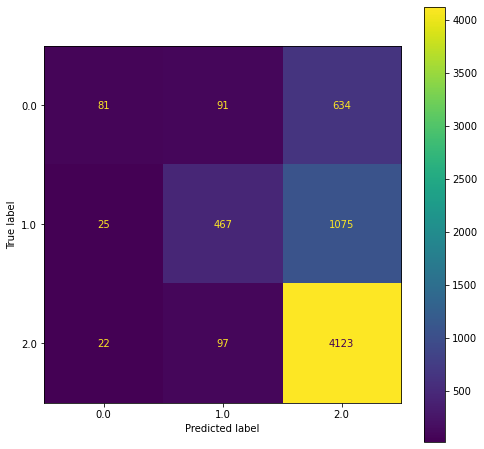

In [198]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,8)
plot_confusion_matrix(cat_clf, X_val, y_val)
plt.show()

In [199]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)

Learning rate set to 0.092455
0:	learn: 1.0466372	total: 7.13ms	remaining: 7.12s
1:	learn: 1.0048780	total: 12.2ms	remaining: 6.09s
2:	learn: 0.9713000	total: 18.4ms	remaining: 6.11s
3:	learn: 0.9444118	total: 27.4ms	remaining: 6.82s
4:	learn: 0.9221270	total: 35.7ms	remaining: 7.11s
5:	learn: 0.9038357	total: 44.1ms	remaining: 7.31s
6:	learn: 0.8884680	total: 52.8ms	remaining: 7.48s
7:	learn: 0.8756787	total: 60.5ms	remaining: 7.5s
8:	learn: 0.8648179	total: 70.4ms	remaining: 7.75s
9:	learn: 0.8555692	total: 79.5ms	remaining: 7.87s
10:	learn: 0.8479161	total: 88.7ms	remaining: 7.97s
11:	learn: 0.8413877	total: 96.8ms	remaining: 7.97s
12:	learn: 0.8354811	total: 105ms	remaining: 7.97s
13:	learn: 0.8307373	total: 114ms	remaining: 8.01s
14:	learn: 0.8272379	total: 123ms	remaining: 8.04s
15:	learn: 0.8240837	total: 131ms	remaining: 8.04s
16:	learn: 0.8209553	total: 138ms	remaining: 8s
17:	learn: 0.8184619	total: 144ms	remaining: 7.85s
18:	learn: 0.8160571	total: 152ms	remaining: 7.85s
19:

In [201]:
submission.loc[:,1:]=my_submission
submission


,index,0,1,2
0,26457,0.039319,0.102282,0.858400
1,26458,0.057877,0.126531,0.815592
2,26459,0.024423,0.040734,0.934843
3,26460,0.074369,0.098721,0.826910
4,26461,0.025053,0.085505,0.889443
...,...,...,...,...
9995,36452,0.165934,0.195308,0.638758
9996,36453,0.154098,0.234026,0.611876
9997,36454,0.025177,0.053953,0.920870
9998,36455,0.144127,0.133164,0.722709


In [202]:
submission.to_csv('newborn2_cat_submission.csv', index=False)

## stacking

In [207]:
target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [208]:
random_state = 42

In [209]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=11, random_state = random_state)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state = random_state))),
    ('cat', CatBoostClassifier(random_state = random_state, learning_rate = 0.08)),
    ('LGB', LGBMClassifier(random_state = random_state, learning_rate = 0.09, n_estimators = 115)),
    ('XGB', XGBClassifier(random_state = random_state))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    stratify=y, test_size=0.25,
                                                    random_state = random_state)
clf.fit(X_train, y_train).score(X_val, y_val)

0:	learn: 1.0541427	total: 12.8ms	remaining: 12.7s
1:	learn: 1.0168372	total: 17.2ms	remaining: 8.59s
2:	learn: 0.9860380	total: 22.3ms	remaining: 7.43s
3:	learn: 0.9607356	total: 27.5ms	remaining: 6.86s
4:	learn: 0.9388053	total: 32.6ms	remaining: 6.49s
5:	learn: 0.9214564	total: 37.2ms	remaining: 6.17s
6:	learn: 0.9055422	total: 42.3ms	remaining: 6s
7:	learn: 0.8924668	total: 47ms	remaining: 5.83s
8:	learn: 0.8807524	total: 52.1ms	remaining: 5.74s
9:	learn: 0.8705865	total: 58.1ms	remaining: 5.75s
10:	learn: 0.8619972	total: 64.1ms	remaining: 5.76s
11:	learn: 0.8545090	total: 70.4ms	remaining: 5.79s
12:	learn: 0.8481924	total: 76.2ms	remaining: 5.78s
13:	learn: 0.8424825	total: 81.8ms	remaining: 5.76s
14:	learn: 0.8375299	total: 88ms	remaining: 5.78s
15:	learn: 0.8331185	total: 93.7ms	remaining: 5.76s
16:	learn: 0.8295046	total: 99.1ms	remaining: 5.73s
17:	learn: 0.8261168	total: 105ms	remaining: 5.72s
18:	learn: 0.8233052	total: 110ms	remaining: 5.69s
19:	learn: 0.8208652	total: 116

0.7164021164021164

In [210]:
y_pred = clf.predict_proba(X_test)
print(y_pred.shape)
y_val_pred = clf.predict_proba(X_val)

(10000, 3)


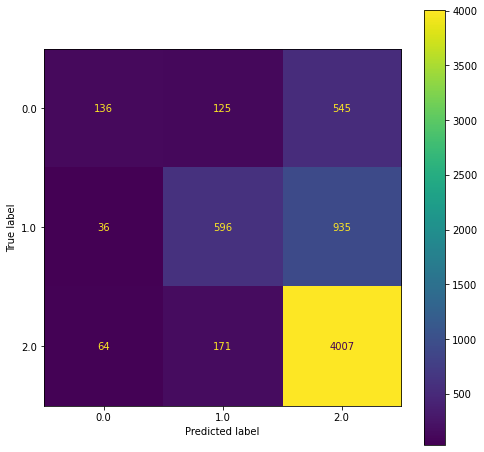

In [212]:
plt.rcParams['figure.figsize'] = (8,8)
plot_confusion_matrix(clf, X_val, y_val)
plt.show()

In [213]:
submission.loc[:,1:] = y_pred
submission.to_csv('newborn2_stacking.csv', index=False)

In [214]:
submission

,index,0,1,2
0,26457,0.076095,0.112521,0.811384
1,26458,0.068095,0.219269,0.712636
2,26459,0.050373,0.096103,0.853524
3,26460,0.070500,0.080645,0.848855
4,26461,0.037921,0.073168,0.888911
...,...,...,...,...
9995,36452,0.136054,0.235554,0.628392
9996,36453,0.328680,0.174322,0.496998
9997,36454,0.046653,0.069459,0.883888
9998,36455,0.153049,0.187426,0.659525
